# OBJECTIVE:
Predict the carbon emissions and energy consumption. 

# KEY FEATURES:

*   ***Entity:*** The name of the country or region for which the data is reported (RELEVANT TO THE INVESTIGATION).

*   ***Year:*** The year for which the data is reported, ranging from 2000 to 2020 (RELEVANT TO THE INVESTIGATION).

*   ***Access to electricity (% of population):*** The percentage of population with access to electricity (RELEVANT TO THE ELECTRICITY FORCASTING).

*   ***Access to clean fuels for cooking (% of population):*** The percentage of the population with primary reliance on clean fuels (RELEVANT TO THE INVESTIGATION).

*   ***Renewable-electricity-generating-capacity-per-capita:*** Installed Renewable energy capacity per person

*   ***Financial flows to developing countries (US $):*** Aid and assistance from developed countries for clean energy projects.

*   ***Renewable energy share in total final energy consumption (%):*** Percentage of renewable energy in final energy consumption.

*   ***Electricity from fossil fuels (TWh):*** Electricity generated from fossil fuels (coal, oil, gas) in terawatt-hours.

*   ***Electricity from nuclear (TWh):*** Electricity generated from nuclear power in terawatt-hours.

*   ***Electricity from renewables (TWh):*** Electricity generated from renewable sources (hydro, solar, wind, etc.) in terawatt-hours.

*   ***Low-carbon electricity (% electricity):*** Percentage of electricity from low-carbon sources (nuclear and renewables).

*   ***Primary energy consumption per capita (kWh/person) -- (TARGET):*** Energy consumption per person in kilowatt-hours.

*   ***Energy intensity level of primary energy (MJ/$2011 PPP GDP):*** Energy use per unit of GDP at purchasing power parity.

*   ***Value_co2_emissions (metric tons per capita) -- (TARGET):*** Carbon dioxide emissions per person in metric tons.

*   ***Renewables (% equivalent primary energy):*** Equivalent primary energy that is derived from renewable sources.

*   ***GDP growth (annual %):*** Annual GDP growth rate based on constant local currency.

*   ***GDP per capita:*** Gross domestic product per person.

*   ***Density (P/Km2):*** Population density in persons per square kilometer.

*   ***Land Area (Km2):*** Total land area in square kilometers.

*   ***Latitude:*** Latitude of the country's centroid in decimal degrees.

*   ***Longitude:*** Longitude of the country's centroid in decimal degrees.

##### NOTE: In parentesis and mayus, we have the variable importance for our investigation (2 targets).

In [1]:
# LIBRARIES:
import pandas as pd
import numpy as np

# IMPUTERS:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# SHOWCASTING THE DATA:
pd.set_option("display.max_column", None)

# TIME SERIES MODELS:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

# GRAPHS:
import matplotlib.pyplot as plt

# ENCODERS:
from sklearn.preprocessing import LabelEncoder 

# METRICS
from sklearn.metrics import mean_squared_error

In [2]:
# FUNTIONS:

def NaNs_calculator(data):
    
    '''SHOWING THE STATS OF MISSING DATA AND DATA TYPE'''

    percentage_missing = (data.isna().mean()*100).sort_values(ascending = False)        # Storing the Percentages of NaNs
    sum_missing = data.isna().sum().sort_values(ascending = False)                      # Storing the Sum of NaNs
    names = sum_missing.index.to_list()                                                 # Storing names (to show in the columns)
    data_type = data[names].dtypes                                                      # Storing the type of data based on the order from the previous obtained data (slicing)
    sum_values = sum_missing.to_list()                                                  # Getting count of missing values
    perc_values = np.around(percentage_missing.to_list(), 3)                            # Getting percentage of missing values
    types = data_type.to_list()                                                         # Getting the types of the data
    # TURN ALL THE DATA INTO A DATAFRAME
    df_missing = pd.DataFrame({"NAMES" : names,                                         
                                    "VALUE COUNT" : sum_values,
                                    "PERCENTAGE (%)" : perc_values,
                                    "DATA TYPE": types})
    return df_missing


def drawing(data, energy_country, Graph_name):
    
    """PLOTTING WITH A FOR LOOP"""
    # plt.figure(figsize=(12, 80))
    # plt.subplot(22, 2, 1)
    # drawing(data[0])

    # Iterate over unique countries and plot their time series    
    for country in data:
        plt.plot(energy_country.loc[energy_country['Entity'] == country].index, energy_country.loc[energy_country['Entity'] == country][Graph_name], label=country)
    
    plt.xlabel('Year')
    plt.ylabel('Energy Consumption per country')
    plt.title('Energy Consumption Over Time (2000-2020)')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()


def data_slicing(data, chunk_number):
    """THIS FUNCTION WILL SLICE THE DATA FRAME INTO SMALER PIECES. FOR EXAMPLE, PASSING THE COUNTRIES IN WILL PROVIDE THE LABELS FOR YOUR GRAPHS"""
    
    # EXTRACTING THE CHUCKS
    segment_numbers = int(len(data)/chunk_number)           # for example a chunk_number of 4 will give 4 segments of 44 rows per chunk. 
    sliced_df = []                                          # Stored chunks
    segment = None                                          # to store the slice 

    for chunk in range(0, len(data), segment_numbers):
        segment = data[chunk:chunk + segment_numbers]       # Start index to the end
        sliced_df.append(segment)                           # Storing the segment

    return sliced_df

def country_selection(data_frame, country):
    '''
    WHAT THE FUNCTION DOES:
    
        1. Filter the country we want (create a function from all the countries available). 
        2. After this, we just delete the country 
        3. Convert the data into data type and pass it to the index (so we have the TS as we need it).
        4. Train and model.
    '''
    # DEFINING THE COUNTRY
    final_data = data_frame[data_frame['Entity'] == country]           # Getting the data from the country we need
    
    # DROPPING THE COLUMN 
    final_data = final_data.drop(columns='Entity')
    
    # PASSING THE YEARS AS INDEX AND PARSING THEM INTO A DATA TYPE:
    final_data.index = pd.to_datetime(final_data['Year'], format = '%Y')        # Years as datetype and stacked as indexes
    final_data.index.freq = 'YS'                                                # Set frequency to yearly starting from January 1st
    
    # DROPPING THE COLUMN YEAR
    final_data = final_data.drop(columns = 'Year')
    
    return final_data

In [3]:
# IMPORTING DATA:
df = pd.read_csv(r"/Users/alberto/Desktop/PROJECTS/ML on Cloud - AI Master_Assigment_1/global-data-on-sustainable-energy.csv")
df.head()

Entity  Year  Access to electricity (% of population)  \
0  Afghanistan  2000                                 1.613591   
1  Afghanistan  2001                                 4.074574   
2  Afghanistan  2002                                 9.409158   
3  Afghanistan  2003                                14.738506   
4  Afghanistan  2004                                20.064968   

   Access to clean fuels for cooking  \
0                                6.2   
1                                7.2   
2                                8.2   
3                                9.5   
4                               10.9   

   Renewable-electricity-generating-capacity-per-capita  \
0                                               9.22      
1                                               8.86      
2                                               8.47      
3                                               8.09      
4                                               7.75      

   Financial flows to developing countries (US $)  \
0                                         20000.0   
1                                        130000.0   
2                                       3950000.0   
3                                      25970000.0   
4                                             NaN   

   Renewable energy share in the total final energy consumption (%)  \
0                                              44.99                  
1                                              45.60                  
2                                              37.83                  
3                                              36.66                  
4                                              44.24                  

   Electricity from fossil fuels (TWh)  Electricity from nuclear (TWh)  \
0                                 0.16                             0.0   
1                                 0.09                             0.0   
2                                 0.13                             0.0   
3                                 0.31                             0.0   
4                                 0.33                             0.0   

   Electricity from renewables (TWh)  Low-carbon electricity (% electricity)  \
0                               0.31                               65.957440   
1                               0.50                               84.745766   
2                               0.56                               81.159424   
3                               0.63                               67.021280   
4                               0.56                               62.921350   

   Primary energy consumption per capita (kWh/person)  \
0                                          302.59482    
1                                          236.89185    
2                                          210.86215    
3                                          229.96822    
4                                          204.23125    

   Energy intensity level of primary energy (MJ/$2017 PPP GDP)  \
0                                               1.64             
1                                               1.74             
2                                               1.40             
3                                               1.40             
4                                               1.20             

   Value_co2_emissions_kt_by_country  \
0                         760.000000   
1                         730.000000   
2                        1029.999971   
3                        1220.000029   
4                        1029.999971   

   Renewables (% equivalent primary energy)  gdp_growth  gdp_per_capita  \
0                                       NaN         NaN             NaN   
1                                       NaN         NaN             NaN   
2                                       NaN         NaN      179.426579   
3                                       NaN    8.832278      190.683

# FORMATTING DATA AND REMOVING THE DATA THAT IS NOT NEEDED:
We are leaving the columns Entity, Value_co2_emissions_kt_by_country (Target 2) and Primary energy consumption per capita (kWh/person) (Target 1)

In [4]:
# DROPPING ALL THE COLUMNS:
data_filtered = df[['Entity', 'Year', 'Value_co2_emissions_kt_by_country', 'Primary energy consumption per capita (kWh/person)']]
data_filtered.head(23)

Entity  Year  Value_co2_emissions_kt_by_country  \
0   Afghanistan  2000                         760.000000   
1   Afghanistan  2001                         730.000000   
2   Afghanistan  2002                        1029.999971   
3   Afghanistan  2003                        1220.000029   
4   Afghanistan  2004                        1029.999971   
5   Afghanistan  2005                        1549.999952   
6   Afghanistan  2006                        1759.999990   
7   Afghanistan  2007                        1769.999981   
8   Afghanistan  2008                        3559.999943   
9   Afghanistan  2009                        4880.000114   
10  Afghanistan  2010                        7110.000134   
11  Afghanistan  2011                        8930.000305   
12  Afghanistan  2012                        8079.999924   
13  Afghanistan  2013                        5989.999771   
14  Afghanistan  2014                        4880.000114   
15  Afghanistan  2015                        5949.999809   
16  Afghanistan  2016                        5300.000191   
17  Afghanistan  2017                        4780.000210   
18  Afghanistan  2018                        6070.000172   
19  Afghanistan  2019                        6079.999924   
20  Afghanistan  2020                                NaN   
21      Albania  2000                        3170.000000   
22      Albania  2001                        3230.000000   

    Primary energy consumption per capita (kWh/person)  
0                                           302.59482   
1                                           236.89185   
2                                           210.86215   
3                                           229.96822   
4                                           204.23125   
5                                           252.06912   
6                                           304.42090   
7                                           354.27990   
8                                           607.83350   
9                                           975.04816   
10                                         1182.89200   
11                                         1436.11430   
12                                         1324.12110   
13                                         1060.79260   
14                                          868.57620   
15                                          970.08030   
16                                          862.79114   
17                                          829.31195   
18                                          924.25085   
19                                          802.61255   
20                                          702.88800   
21                                         9029.43750   
22                                         8635.53200

In [5]:
# FORMATTING THE COLUMN NAMES SO IT IS EASIER TO HANDLE THEM (PUTTING THE '_' ON ANY SPACE):
for x in data_filtered.columns:
    if x == "Value_co2_emissions_kt_by_country":
        name = x.replace("Value_co2_emissions_kt_by_country", "CO2_EMISSIONS")
        data_filtered = data_filtered.rename(columns={x: name})
    elif x == "Primary energy consumption per capita (kWh/person)":
        name = x.replace("Primary energy consumption per capita (kWh/person)", "ENERGY_CONSUMPTION(KWH/PERSON)")
        data_filtered = data_filtered.rename(columns={x: name})
data_filtered.head()

Entity  Year  CO2_EMISSIONS  ENERGY_CONSUMPTION(KWH/PERSON)
0  Afghanistan  2000     760.000000                       302.59482
1  Afghanistan  2001     730.000000                       236.89185
2  Afghanistan  2002    1029.999971                       210.86215
3  Afghanistan  2003    1220.000029                       229.96822
4  Afghanistan  2004    1029.999971                       204.23125

In [6]:
# SIZE OF THE DATA:
print(f'The number of rows is: {data_filtered.shape[0]}')
print(f'The number of columns is: {data_filtered.shape[1]}')

The number of rows is: 3649
The number of columns is: 4


We only want to impute on the training set and then use that imputer to fill in the date for the test set. Otherwise we are leaking data (cheating by giving future information to the model).

Let's format the data frame by passing the Years to the index (to make it a TS) and split the data after that. 

In TS, we cannot split the data randombly. We need to create a train, test and validation set.

Finally, we are creating the model for one country only so we are able to reproduce it to the other ones.

Let's follow this:

    1. Filter the country we want (create a function from all the countries available). 
    2. After this, we just delete the country 
    3. Convert the data into data type and pass it to the index (so we have the TS as we need it).
    4. Train and model.

In [7]:
# countries = data_filtered['Entity'].unique()

# for i in range(0, len(countries), 22):
#     print("Group", i // 22 + 1)
#     print(countries[i:i+22])
#     print()

In [8]:
final_data = country_selection(data_filtered, 'Colombia')
final_data

CO2_EMISSIONS  ENERGY_CONSUMPTION(KWH/PERSON)
Year                                                     
2000-01-01    58340.00000                       8011.8125
2001-01-01    58940.00000                       7953.8550
2002-01-01    56770.00046                       7834.4710
2003-01-01    56110.00061                       7863.6520
2004-01-01    56110.00061                       8152.3345
2005-01-01    57639.99939                       7917.9070
2006-01-01    57689.99863                       9024.0930
2007-01-01    59180.00031                       9058.0020
2008-01-01    59779.99878                       9322.7670
2009-01-01    62009.99832                       9111.8610
2010-01-01    63560.00137                       9474.2960
2011-01-01    69099.99847                       9794.9110
2012-01-01    69699.99695                      10308.1720
2013-01-01    76860.00061                      10490.0810
2014-01-01    79199.99695                      10938.4810
2015-01-01    80230.00336                      10259.0400
2016-01-01    82680.00031                      11435.3030
2017-01-01    74989.99786                      11368.8340
2018-01-01    78589.99634                      11332.2470
2019-01-01    81040.00092                      11221.7870
2020-01-01            NaN                      10064.3890

# CHECKING AND HANDLING MISSING VALUES AND DATA TYPE:

In [9]:
# MISSING DATA ON THE DATASET (TOTAL): (This goes before the describe)
to_impute = NaNs_calculator(final_data)# Basically, I am calling again the data frame to filter it
to_impute

NAMES  VALUE COUNT  PERCENTAGE (%) DATA TYPE
0                   CO2_EMISSIONS            1           4.762   float64
1  ENERGY_CONSUMPTION(KWH/PERSON)            0           0.000   float64

Let's impute the values:

In [10]:
'''THIS GOES AFTER THE SPLIT OF DATA'''
# IMPUTING VALUES WITH THE IMPUTER: GETTING THE COLUMNS WHERE WE WANT TO IMPUTE (NOT THE ONE WITH ZERO NaNs):
                                         
names_to_impute = to_impute[to_impute["PERCENTAGE (%)"] > 0]["NAMES"].tolist()      # Leaving out the columns that got no NaNs
col = final_data[names_to_impute]                                                # Selecting only the column names to be imputed

# IMPUTING:
imputer = IterativeImputer(max_iter=10, random_state=0)                             # instantiating the imputer
imputed_col = imputer.fit_transform(col)                                            # Fitting the new data to the columns
final_data.loc[:, names_to_impute] = imputed_col                                  # Replace the imputed values back into the original DataFrame                    
final_data

CO2_EMISSIONS  ENERGY_CONSUMPTION(KWH/PERSON)
Year                                                     
2000-01-01   58340.000000                       8011.8125
2001-01-01   58940.000000                       7953.8550
2002-01-01   56770.000460                       7834.4710
2003-01-01   56110.000610                       7863.6520
2004-01-01   56110.000610                       8152.3345
2005-01-01   57639.999390                       7917.9070
2006-01-01   57689.998630                       9024.0930
2007-01-01   59180.000310                       9058.0020
2008-01-01   59779.998780                       9322.7670
2009-01-01   62009.998320                       9111.8610
2010-01-01   63560.001370                       9474.2960
2011-01-01   69099.998470                       9794.9110
2012-01-01   69699.996950                      10308.1720
2013-01-01   76860.000610                      10490.0810
2014-01-01   79199.996950                      10938.4810
2015-01-01   80230.003360                      10259.0400
2016-01-01   82680.000310                      11435.3030
2017-01-01   74989.997860                      11368.8340
2018-01-01   78589.996340                      11332.2470
2019-01-01   81040.000920                      11221.7870
2020-01-01   66925.999512                      10064.3890

In [11]:
# CHECKING THE DATA STATISTIC OF THE DATA: 
final_data.describe().transpose()

count          mean          std          min  \
CO2_EMISSIONS                    21.0  66925.999512  9695.183391  56110.00061   
ENERGY_CONSUMPTION(KWH/PERSON)   21.0   9568.490286  1286.974553   7834.47100   

                                       25%          50%          75%  \
CO2_EMISSIONS                   58340.0000  63560.00137  76860.00061   
ENERGY_CONSUMPTION(KWH/PERSON)   8152.3345   9474.29600  10490.08100   

                                        max  
CO2_EMISSIONS                   82680.00031  
ENERGY_CONSUMPTION(KWH/PERSON)  11435.30300

# VERIFYING THE STATIONARITY OF THE TIME SERIES:

    1. Plotting to have glimpse.
    2. Runnung the ADF

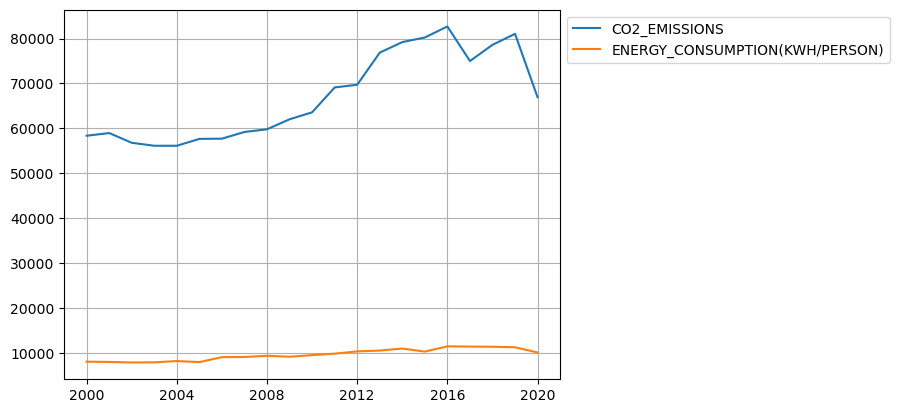

In [12]:
plt.plot(final_data);
plt.legend(final_data.columns, bbox_to_anchor=(1, 1), loc='upper left');
plt.grid()

As we can see in the plots, there are some marked trends and seasonalities that makes the Time series not to be stationary (At least for the CO2 Emssions). 

It is recommendable to work with stationaries Time series. On the other hand, we need to use a more robust way of checking the stationarity of a Time series. For this, we are going to uuse the test ***Augmented Dickey-Fuller test (ADF Test)***.

Without entering in details on the math considerations, we need to check this condition:
    
    "The p_value has to be less than 0.05 (5%)".

Since we have two variables, then, I will run the test for the targets only (those are the ones I want to calculate) Co2 and Energy consumption per country.


# PENDING TO CHECK THIS: https://www.analyticsvidhya.com/blog/2018/09/an-introduction-to-non-stationary-time-series-in-python/

In [13]:
# ENERGY:
ad_fuller_EC = adfuller(final_data['ENERGY_CONSUMPTION(KWH/PERSON)'])
print("ADF test for 'ENERGY_CONSUMPTION(KWH/PERSON)':\n")
print(f"\t1. ADF Statistic: {ad_fuller_EC[0]}")
print(f'\t2. P-value: {ad_fuller_EC[1]}\n')

# CO2:
ad_fuller_CO2 = adfuller(final_data['CO2_EMISSIONS'])
print("ADF test for CO2_EMISSIONS:\n")
print(f"\t1. ADF Statistic: {ad_fuller_CO2[0]}")
print(f'\t2. P-value: {ad_fuller_CO2[1]}\n')

ADF test for 'ENERGY_CONSUMPTION(KWH/PERSON)':

	1. ADF Statistic: -2.259879440063583
	2. P-value: 0.1852341907683317

ADF test for CO2_EMISSIONS:

	1. ADF Statistic: -1.3268023640979596
	2. P-value: 0.6168227572701093



As we can see here, the test is showing us a p-value greater than 0.05 in both cases, which means the series is not stationary.
Let's try to make it stationary.

In [14]:
# IN THIS CASE, WE ARE GOING TO USE .diff BUT LATER ON, WE CAN CHECK WHAT ELSE WE CAN USE.

# ENERGY:
ad_fuller_EC = adfuller(final_data['ENERGY_CONSUMPTION(KWH/PERSON)'].diff()[1:])
print("ADF test for 'ENERGY_CONSUMPTION(KWH/PERSON)':\n")
print(f"\t1. ADF Statistic: {ad_fuller_EC[0]}")
print(f'\t2. P-value: {ad_fuller_EC[1]}\n')

# CO2:
ad_fuller_CO2 = adfuller(final_data['CO2_EMISSIONS'].diff()[1:])
print("ADF test for CO2_EMISSIONS:\n")
print(f"\t1. ADF Statistic: {ad_fuller_CO2[0]}")
print(f'\t2. P-value: {ad_fuller_CO2[1]}\n')

ADF test for 'ENERGY_CONSUMPTION(KWH/PERSON)':

	1. ADF Statistic: -0.02453277005822786
	2. P-value: 0.9564556050235775

ADF test for CO2_EMISSIONS:

	1. ADF Statistic: -1.151434145675984
	2. P-value: 0.6941311472407244



Now, we can see that the series are stationary for the energy consumption.

Another aspect to have in mind is to check if the series are correlating to each other. To check this information, we are going to make use of the granger Casualty test. The test works like this:

*"The data for testing whether the time series in the second column Granger causes the time series in the first column. (Missing values are not supported that is why we cleaned the data frame)".*

Source:

    a. https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/
    b. https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html

To interpret the test, we should take a look at he P values given. It should be again, less than 0.05

# SPLITTING THE DATA INTO TRAIN, AND TEST:

    1. We need to extract the column we are going to work with.
    2. Splitting the data (not ramdomizing it since it is a time series)

In [15]:
#creating the train and validation set
train = final_data[:int(0.8*(len(final_data)))]
valid = final_data[int(0.8*(len(final_data))):]
train.shape, valid.shape

((16, 2), (5, 2))

# TRAINING THE MODEL:

In [16]:
model = VAR(endog=train)
model_fit = model.fit()

# MAKING PREDICTIONS ON THE VALIDATION SET:

In [17]:
prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

# MAKING IT PRESENTABLE
The predictions are in the form of an array, where each list represents the predictions of the row. We will transform this into a more presentable format.

In [18]:
#converting predictions to dataframe
cols = final_data.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0, prediction.shape[1]):
    for i in range(0, len(prediction)):
       pred.iloc[i, j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for CO2_EMISSIONS is :  8313.744910539717
rmse value for ENERGY_CONSUMPTION(KWH/PERSON) is :  806.187866651432


In [24]:
#make final predictions
model = VAR(endog=final_data)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.endog, steps=10)
print(yhat)

[[68711.7257006   9995.82543309]
 [69525.05132724 10004.14147744]
 [69998.50153708 10034.47189002]
 [70340.50578988 10069.23685007]
 [70621.04652378 10102.97863928]
 [70864.78006747 10134.16339409]
 [71081.40676191 10162.5118126 ]
 [71275.58736651 10188.13159051]
 [71450.19139402 10211.23683677]
 [71607.37056484 10232.05858187]]


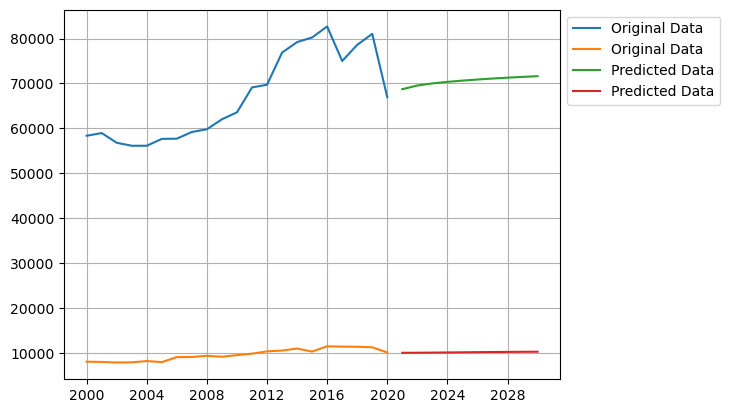

In [25]:
import matplotlib.pyplot as plt

# Plot original data
plt.plot(final_data, label='Original Data')

# Plot predicted values
plt.plot(pd.date_range(start=final_data.index[-1], periods=len(yhat), freq='YE'), yhat, label='Predicted Data')

# Add legend and grid
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()

# Show plot
plt.show()
